In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
warnings.filterwarnings('ignore')
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Word vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv("D:/DS Class/Fliprobo/Malignant Comments Classifier Project/train.csv")
df.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [4]:
#No null values
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [5]:
#There are many words and quotes which are not necessary for our model which we will remove

#Let's do some plotting

In [6]:
df.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see that from data description mean of all the columns are less than 0.5, which means less number of messages are malignant, rude, abusive than non malignant, not rude, non abusive, etc.

In [7]:
df.drop(['id'],axis=1,inplace=True)

In [8]:
#Number of True messages in each columns, for e.g. Malignant messages frm Malignant columns, etc.

n_all = df.shape[0]
n_malignant = df['malignant'].sum()
n_hmalignant = df['highly_malignant'].sum()
n_rude = df['rude'].sum()
n_threat = df['threat'].sum()
n_abuse = df['abuse'].sum()
n_loathe = df['loathe'].sum()
df1 = [n_all, n_malignant, n_hmalignant, n_rude, n_threat, n_abuse, n_loathe]
df2 = ['all', 'malignant', 'highly malignant', 'rude', 'threat', 'abuse', 'loathe']

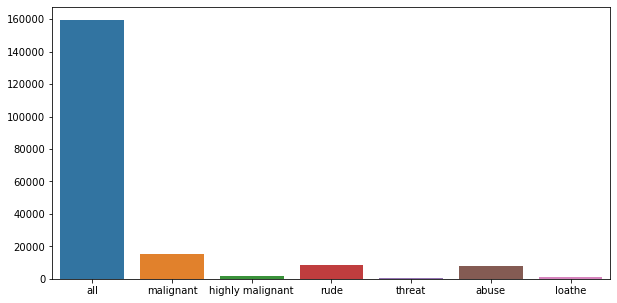

In [9]:
plt.figure(figsize=(10,5))
sns.barplot(df2,df1)

Most number of negtive messages are malignant > rude > abuse > highly_malignant > loathe > threat

Threats are the least kind of negative messages

# Data cleaning

In [10]:
#Punctuation remove
punc_removed = lambda x: re.sub(r'[^\w\s]', '', x)

#lowercase
lower_case = lambda x: x.lower()

# \n to space

n_removed = lambda x: re.sub('\n', ' ', x)

In [11]:
#Applying the lambda functions on dataset

df['comment_text'] = df['comment_text'].map(punc_removed).map(lower_case).map(n_removed)

In [12]:
df['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired now892053827'

In [13]:
#There are some alphanumeric words which have literally no meaning, let's remove them as well

#Alphanumerics remove
alnum_removed = lambda x: re.sub('\w*\d\w*', ' ', x)

In [14]:
#Applying the lambda functions on dataset

df['comment_text'] = df['comment_text'].map(alnum_removed)

In [15]:
df['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired  '

In [16]:
#Stripping of spaces and replacing multi spaces with one

strip_msg_start = lambda x: re.sub('^\s+', '', x)
strip_msg_end = lambda x: re.sub('\s+$', '', x)
mul_to_one = lambda x: re.sub('\s+', ' ', x)

df['comment_text'] = df['comment_text'].map(strip_msg_start).map(strip_msg_end).map(mul_to_one)
df['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired'

In [17]:
df['comment_text'][1]

'daww he matches this background colour im seemingly stuck with thanks talk january utc'

# Making our datasets in such a way that we can classify into each of the classifications namely ['malignant', 'highly malignant', 'rude', 'threat', 'abuse', 'loathe']

In [18]:
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, log_loss, roc_auc_score, roc_curve

#import models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

In [19]:
df['comment_text'][1]

'daww he matches this background colour im seemingly stuck with thanks talk january utc'

In [20]:
lemma = WordNetLemmatizer()

In [21]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91995\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
print(lemma.lemmatize('matches'))

match


In [23]:
def lemmatization(x):
    x = x.split(' ')
    arr = []
    for i in x:
        arr.append(lemma.lemmatize(i))
        strarr1 = " ".join(arr)
    return strarr1

In [24]:
df['comment_text'].map(lemmatization)

0         explanation why the edits made under my userna...
1         daww he match this background colour im seemin...
2         hey man im really not trying to edit war it ju...
3         more i cant make any real suggestion on improv...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566    and for the second time of asking when your vi...
159567    you should be ashamed of yourself that is a ho...
159568    spitzer umm there no actual article for prosti...
159569    and it look like it wa actually you who put on...
159570    and i really dont think you understand i came ...
Name: comment_text, Length: 159571, dtype: object

In [25]:
#We have to divide our dataset into 6 parts and each part will have 2 columns, message and one of the classification.

data1 = df[['comment_text', 'malignant']]
data2 = df[['comment_text', 'highly_malignant']]
data3 = df[['comment_text', 'rude']]
data4 = df[['comment_text', 'threat']]
data5 = df[['comment_text', 'abuse']]
data6 = df[['comment_text', 'loathe']]

#Initializing models

lr = LogisticRegression()
knc = KNeighborsClassifier(n_neighbors=5)
mnb = MultinomialNB()
bnb = BernoulliNB()
svc = SVC()
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

In [26]:
ngram11 = (1,1)
vect = TfidfVectorizer(smooth_idf=False, ngram_range=ngram11)
def tfidf_model(df, label, ngram):
    X = df['comment_text']
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    print("X Train shape:", X_train_vect.shape,"X Test shape:", X_test_vect.shape)
    lr.fit(X_train_vect , y_train)
    print('lr done')
    knc.fit(X_train_vect , y_train)
    print('knc done')
    mnb.fit(X_train_vect , y_train)
    print('mnb done')
    bnb.fit(X_train_vect , y_train)
    print('bnb done')
    svc.fit(X_train_vect , y_train)
    print('svc done')
    etc.fit(X_train_vect , y_train)
    print('etc done')
    rfc.fit(X_train_vect , y_train)
    print('rfc done')
    f1scores = {'F1 Score': [f1_score(lr.predict(X_test_vect), y_test), f1_score(knc.predict(X_test_vect), y_test),
                             f1_score(mnb.predict(X_test_vect), y_test), f1_score(bnb.predict(X_test_vect), y_test), 
                             f1_score(svc.predict(X_test_vect), y_test), f1_score(etc.predict(X_test_vect), y_test), 
                             f1_score(rfc.predict(X_test_vect), y_test)]}
    df_scores = pd.DataFrame(f1scores, index = ['LogisticRegression', 'KNeighborsClassifier', 'MultinomialNB', 
                                                'BernoulliNB', 'SVC', 'ExtraTreesClassifier', 'RandomForestClassifier'])
    
    return df_scores

In [27]:
df_mal = tfidf_model(data1, 'malignant', ngram11)
df_mal

X Train shape: (111699, 173334) X Test shape: (47872, 173334)
lr done
knc done
mnb done
bnb done
svc done
etc done
rfc done


,F1 Score
LogisticRegression,0.723219
KNeighborsClassifier,0.221714
MultinomialNB,0.244164
BernoulliNB,0.625265
SVC,0.741611
ExtraTreesClassifier,0.598573
RandomForestClassifier,0.547949


In [28]:
#SVC model is working best, let's put it for other datasets

def tfidf_model_SVC(df, label, ngram):
    X = df['comment_text']
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    X_train_vect = vect.transform(X_train)
    X_test_vect = vect.transform(X_test)
    svc.fit(X_train_vect , y_train)
    print('svc done')
    f1scores = {'F1 Score': [f1_score(svc.predict(X_test_vect), y_test)]}
    df_scores = pd.DataFrame(f1scores, index = ['SVC'])
    
    return df_scores

In [29]:
#SVC prediction model

def tfidf_model_SVC_pred(df, ngram):
    X = df['comment_text']
    X_test_vect = vect.transform(X)
    pred1 = svc.predict(X_test_vect)
    return pred1

In [30]:
t_df = pd.read_csv("D:/DS Class/Fliprobo/Malignant Comments Classifier Project/train.csv")
t_df.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [31]:
#cleaning

t_df.drop(['id'],axis=1,inplace=True)
t_df['comment_text'] = t_df['comment_text'].map(punc_removed).map(lower_case).map(n_removed).map(alnum_removed).map(strip_msg_start).map(strip_msg_end).map(mul_to_one)
t_df['comment_text'].map(lemmatization)

0         explanation why the edits made under my userna...
1         daww he match this background colour im seemin...
2         hey man im really not trying to edit war it ju...
3         more i cant make any real suggestion on improv...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566    and for the second time of asking when your vi...
159567    you should be ashamed of yourself that is a ho...
159568    spitzer umm there no actual article for prosti...
159569    and it look like it wa actually you who put on...
159570    and i really dont think you understand i came ...
Name: comment_text, Length: 159571, dtype: object

In [32]:
t_data1 = t_df[['comment_text', 'malignant']]
t_data2 = t_df[['comment_text', 'highly_malignant']]
t_data3 = t_df[['comment_text', 'rude']]
t_data4 = t_df[['comment_text', 'threat']]
t_data5 = t_df[['comment_text', 'abuse']]
t_data6 = t_df[['comment_text', 'loathe']]

In [33]:
#After uploading the test.csv run these cells
df_mal = tfidf_model_SVC(data1, 'malignant', ngram11)
t_df1_mal = tfidf_model_SVC_pred(t_data1, ngram11)
t_df1_mal

svc done


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [34]:
df2_mal = tfidf_model_SVC(data2, 'highly_malignant', ngram11)
t_df2_mal = tfidf_model_SVC_pred(t_data2, ngram11)
t_df2_mal

svc done


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [35]:
df3_rude = tfidf_model_SVC(data3, 'rude', ngram11)
t_df3_rude = tfidf_model_SVC_pred(t_data3, ngram11)
t_df3_rude

svc done


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [36]:
df4_threat = tfidf_model_SVC(data4, 'threat', ngram11)
t_df4_threat = tfidf_model_SVC_pred(t_data4, ngram11)
t_df4_threat

svc done


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [37]:
df5_abuse = tfidf_model_SVC(data5, 'abuse', ngram11)
t_df5_abuse = tfidf_model_SVC_pred(t_data5, ngram11)
t_df5_abuse

svc done


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [38]:
df6_loathe = tfidf_model_SVC(data6, 'loathe', ngram11)
t_df6_loathe = tfidf_model_SVC_pred(t_data6, ngram11)
t_df6_loathe

svc done


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)